<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/split-step-fourier-method-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # allows vectorized operations

import cupy as cp # fork of numpy
# allows vectorized coperations on GPU

import time

import matplotlib.pyplot as plt
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                       
Lambda = 0.651e-6; # wavelength
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 5; # computational length of sample    
Lx = 1e-4; # computational width of sample          
Chirp = -0.0*6*230000.0; # input linear chirp parameter         
h = 0*0.67e-3;
xshift = +h/2; # input position on x axis               
w0 = 0.02*Lx # beam width of gaussian beam parameter

In [0]:
################## Computational Parameters #############
nstepx = 4096; # number of transverse grid points
nstepz = 20; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step       

In [31]:
print(f"Delta X: {deltax}")

Delta X: 2.44140625e-08


In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array               

X, Y = cp.meshgrid(x,x); # x and y grid

In [0]:
##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = cp.meshgrid(kx, kx);

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# gaussian beam
InputField = cp.sqrt(Ip)*cp.exp(-(X**2+Y**2)/(w0**2));

InputPower = cp.abs(InputField)**2

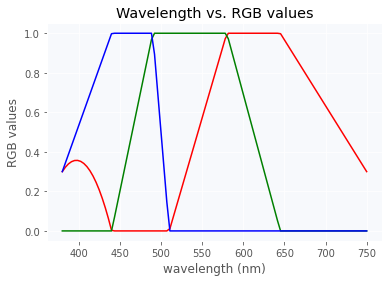

In [7]:
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)

wavelengths = np.linspace(380, 750, 100) # in nanometers
rgbs = np.stack([cp.asnumpy(wavelength_to_rgb(wl)) for wl in wavelengths])
plt.plot(wavelengths, rgbs[:, 0], "r-")
plt.plot(wavelengths, rgbs[:, 1], "g-")
plt.plot(wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.show()

In [0]:
cmap = wavelength_to_cmap(Lambda*1e9) #light at the wavelength used in our experiment

In [0]:
# we define a function to plot 
def plot(Power, figsize=(15, 15), width=15, unit="mm", _cmap=cmap):
  if type(Power)==cp.core.core.ndarray:
    Power = cp.asnumpy(Power)
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, cmap=_cmap, extent=[-width,width,-width,width], vmin=0)
  return fig, ax

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb992d16940>)

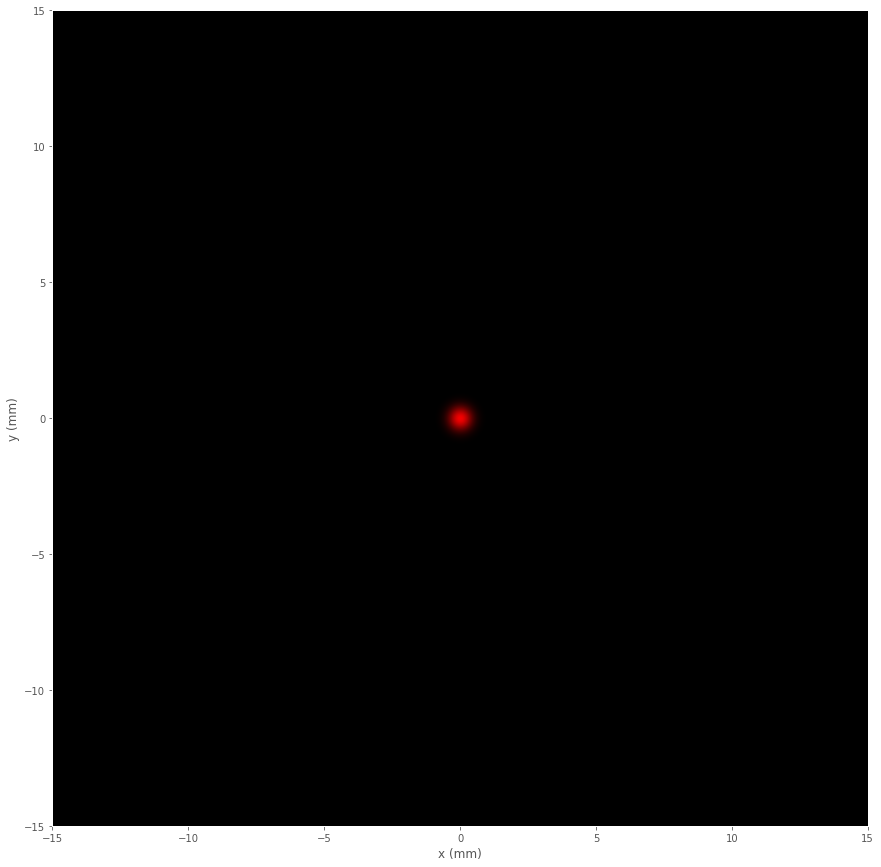

In [63]:
plot(InputPower)

In [0]:
fft2, ifft2 = cp.fft.fft2, cp.fft.ifft2 # faster with big matrices

In [0]:
######                    PROPAGATION LOOP                  ########

def propagate(Field, k, nstepz=nstepz, deltaz=deltaz, keep_memory=False):
  if keep_memory:
    # keeps a record of field module at every step
    FieldModuleMemory = cp.zeros(shape=(nstepx, nstepx, nstepz+1))
    FieldModuleMemory[..., 0] = cp.abs(InputField)
  else:
    FieldModuleMemory = None
  ArgumentOfPropagator  = ((k*n0)**(-1)*(KX**2+KY**2))*(deltaz/2);             
  Propagator = cp.exp(1j*ArgumentOfPropagator)
  tstart = time.time()
  for hh in range(nstepz):
      
      FieldTransform = fft2(Field)*Propagator
      Field = ifft2(FieldTransform)

      if keep_memory:
        FieldModuleMemory[..., 1+hh] = cp.abs(Field)

  print(f"Lasted {time.time()-tstart} seconds")
  return Field, FieldModuleMemory

In [0]:

OutputField, FieldModuleMemory = propagate(InputField, k0, keep_memory=True)
OutputPower = np.abs(OutputField)**2

OutputTotalPower = np.sum(OutputPower) # total power on output plane
InputTotalPower = np.sum(InputPower) # total power on input plane
gap = (OutputTotalPower-InputTotalPower)/(OutputTotalPower+InputTotalPower)

if abs(gap) > 1e-14:
  print(gap)

In [0]:
# we evaluate an estimation of error due to low z resolution
estimate_error = False
if estimate_error:
  high_res_field = np.abs(propagate(InputField, k0, nstepz=200, deltaz=Lz/200))
  low_res_field = np.abs(propagate(InputField, k0, nstepz=20, deltaz=Lz/20))
  error = np.abs(low_res_field-high_res_field)
  max_error = np.max(error)
  print(f"Max_error: {max_error}")

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb9913dcb70>)

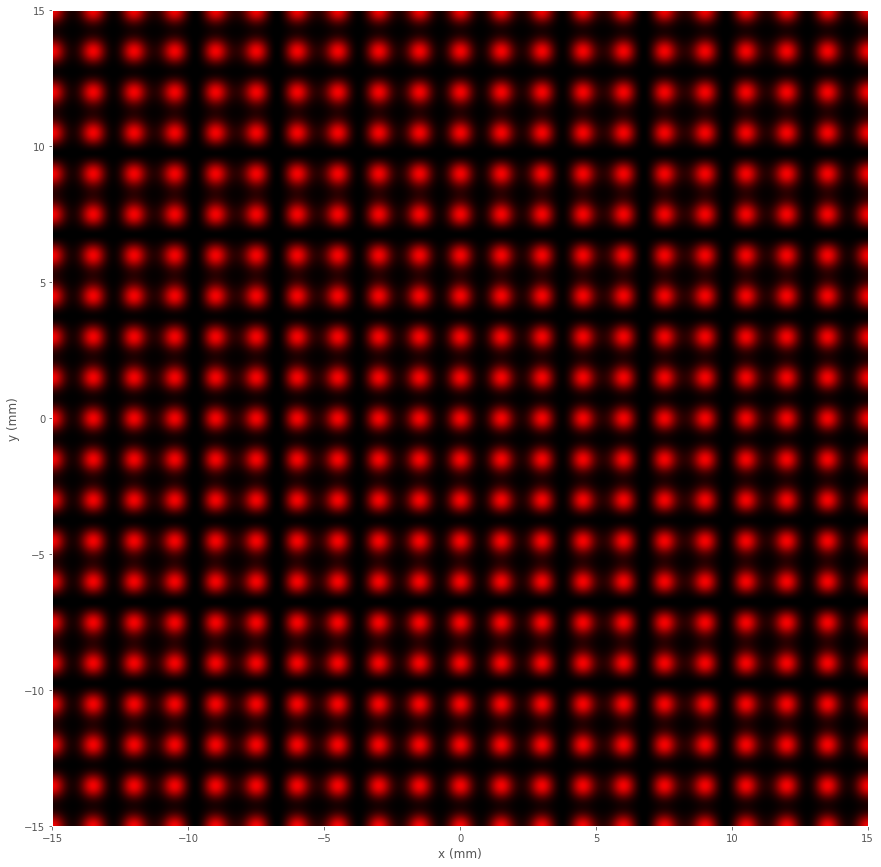

In [68]:
plt.close()
plot(OutputPower)

In [0]:
def propagate_and_get_rgb(InputField, wavelength):
  k = 2*np.pi/(wavelength) #------------------------------------------------
  OutputField = propagate(InputField, k)[0]
  P = cp.abs(OutputField)**2
  rgb = cp.stack((P,)*3, axis=-1)/cp.max(P)
  return rgb*wavelength_to_rgb(wavelength*1e9)

In [0]:

InputField1 = np.sqrt(Ip)*np.exp(1j*Chirp*X-((X-xshift)**2+(Y)**2)/(49*w0**2)); #7x larger
InputField2 = np.sqrt(Ip)*np.exp(1j*Chirp*X-((X-xshift)**2+(Y)**2)/(w0**2));

RedPower = propagate_and_get_rgb(InputField1, 0.645e-6)
BluePower = propagate_and_get_rgb(InputField, 0.44e-6)
plot(RedPower + BluePower) #purple point with red cirle 
# red + blue = purple

In [0]:
# we evaluate beam widths as the 2nd moment of a gaussian function

# extends grids X and Y to a third axis
# in order to make possible multiplying by FieldModuleMemory
_X = np.stack((X,)*(nstepz+1), axis=-1)
_Y = np.stack((Y,)*(nstepz+1), axis=-1)

norms = np.sum(FieldModuleMemory, axis=(0, 1))
widths = np.sqrt(np.sum((_X**2+_Y**2)*FieldModuleMemory, axis=(0, 1))/norms)

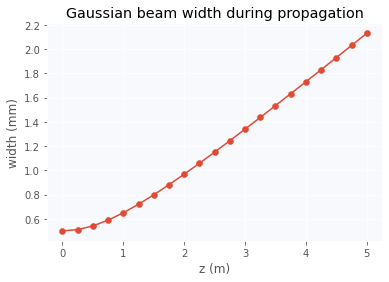

In [0]:
plt.scatter(z, 1000*widths)
z0 = k0*w0**2/2 # Rayleigh's width
plt.plot(z, 1000*w0*np.sqrt(1+z**2/z0**2))
plt.xlabel("z (m)")
plt.ylabel("width (mm)")
plt.title("Gaussian beam width during propagation")
plt.show()

In [0]:
PlaneInputField = 0*X
dist = 1e-6
width = 0.1e-6

d, w = int(dist/deltax), int(width/deltax)
for n in range(int(Lx/dist)):
  PlaneInputField[:, n*d-w : n*d+w] = 1

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8baa5c9d68>)

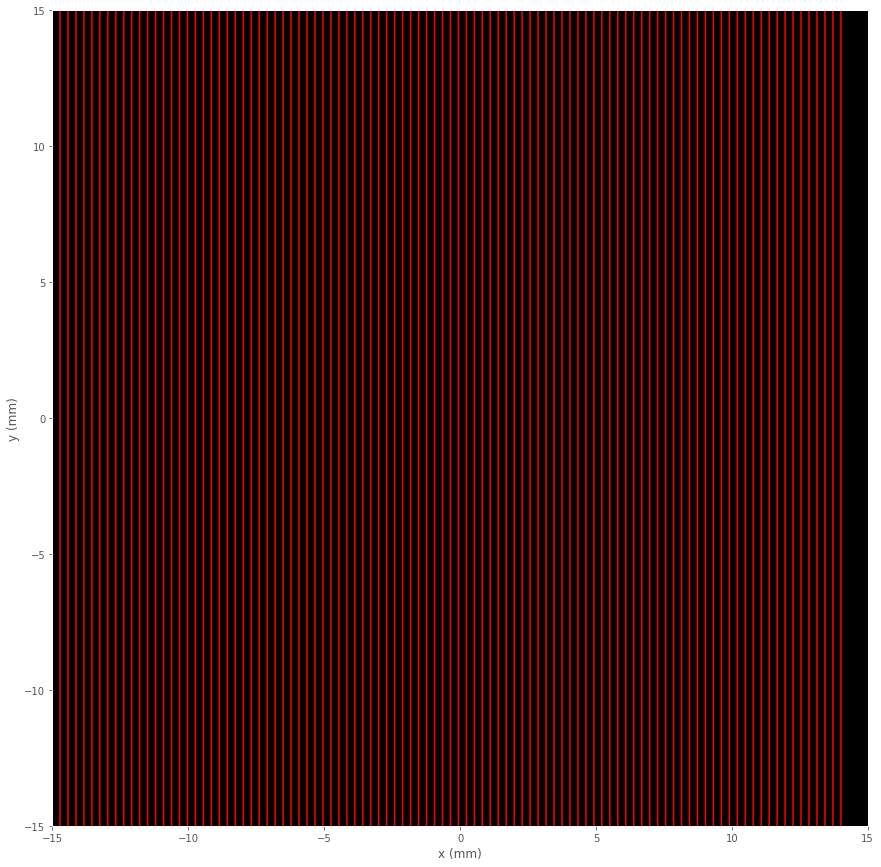

In [36]:
plot(PlaneInputField)

NameError: ignored

In [0]:
cp.get_default_memory_pool().free_all_blocks()

Lasted 0.03524971008300781 seconds
Lasted 0.028511762619018555 seconds


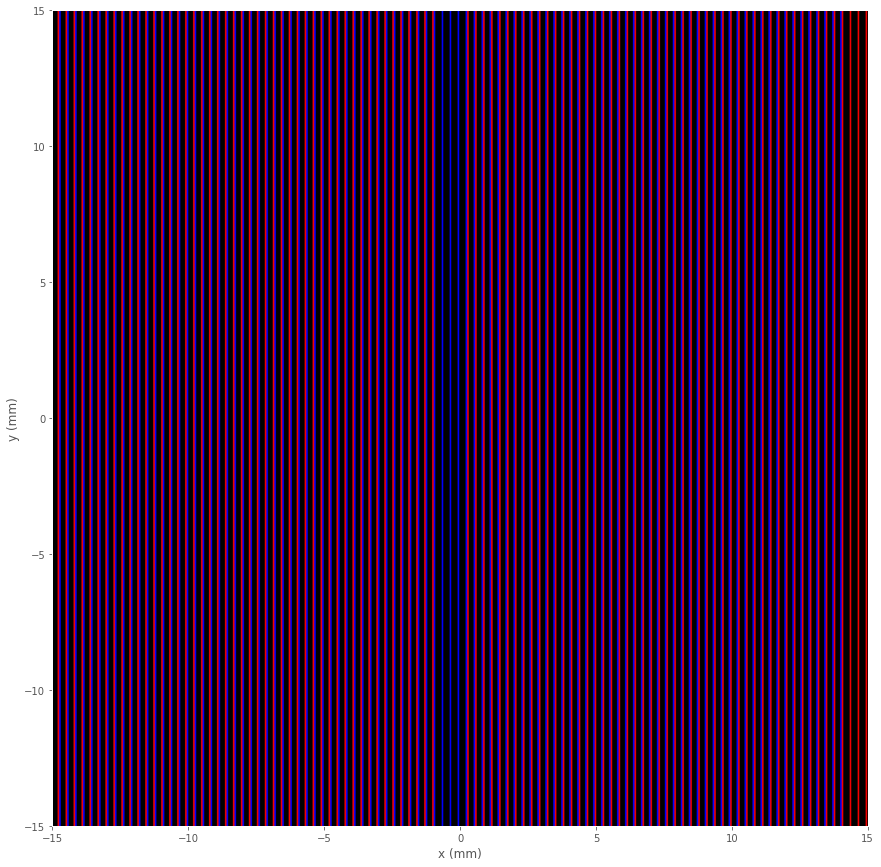

In [37]:
Red = propagate_and_get_rgb(PlaneInputField, 0.65e-6)
Blue = propagate_and_get_rgb(PlaneInputField, 0.44e-6)

fig, ax = plot(Red+Blue)
fig.savefig("4.png")

In [0]:
output = np.zeros(Red.shape)
wavelengths = np.linspace(380, 750, 7) # light with 7 colors
for wl in wavelengths:
 output += propagate_and_get_rgb(PlaneInputField, wl*1e-9)

Lasted 2.095958709716797 seconds
Lasted 2.105328321456909 seconds
Lasted 2.107069730758667 seconds
Lasted 2.1000781059265137 seconds
Lasted 2.1150033473968506 seconds
Lasted 2.0973594188690186 seconds
Lasted 2.1025748252868652 seconds


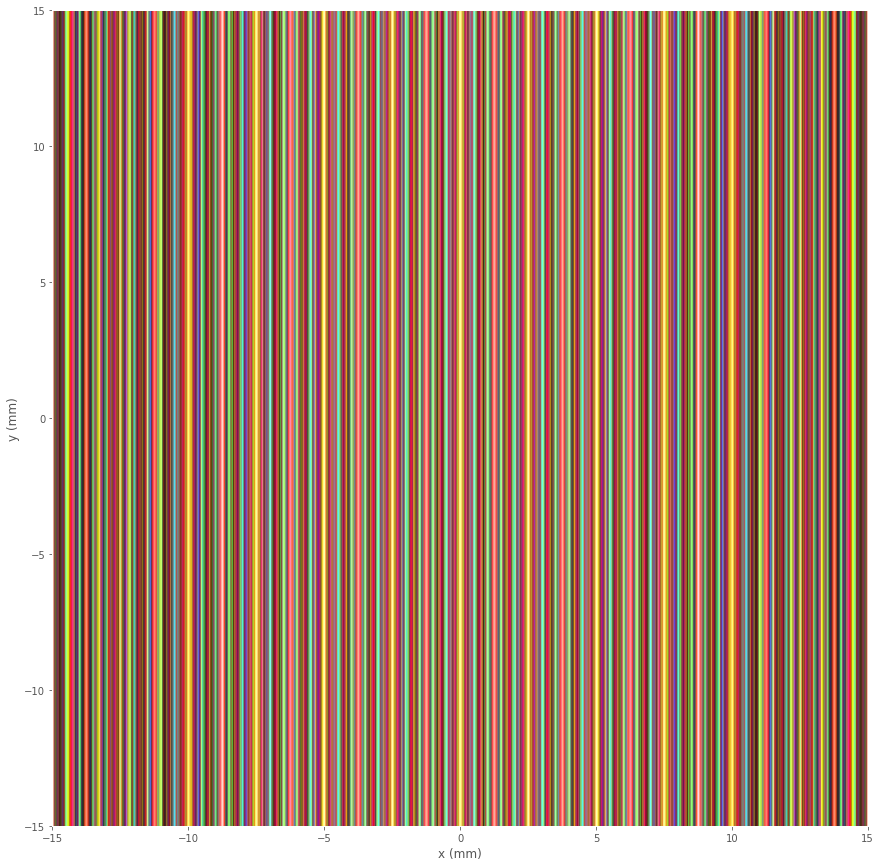

In [0]:
fig, ax = plot(output)
plt.xlabel("x (mm)")
plt.show()
fig.savefig("5.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


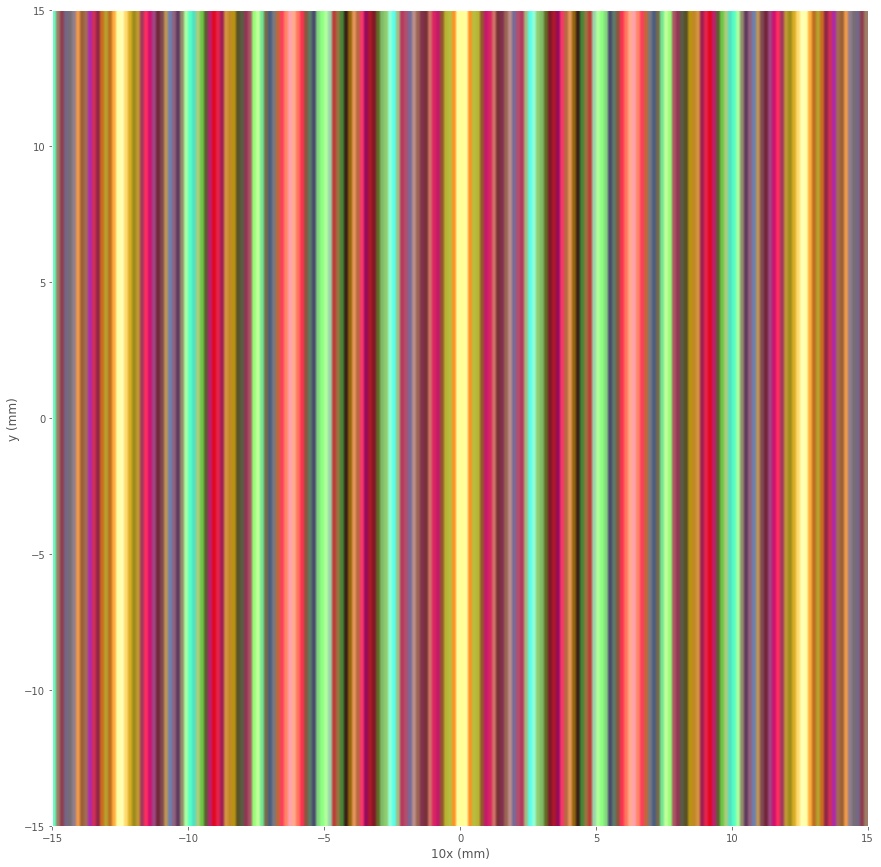

In [0]:
fig. ax = plot(output[:, 512-102:512+102])
plt.xlabel("10x (mm)")
plt.show()
fig.savefig("6.png")

In [0]:
output = np.zeros(Red.shape)
wavelengths = np.linspace(380, 750, 40) # light with 7 colors
for wl in wavelengths:
 output += propagate_and_get_rgb(PlaneInputField, wl*1e-9)

Lasted 2.1772584915161133 seconds
Lasted 2.138681650161743 seconds
Lasted 2.141493082046509 seconds
Lasted 2.147007703781128 seconds
Lasted 2.143617630004883 seconds
Lasted 2.148745536804199 seconds
Lasted 2.151545763015747 seconds
Lasted 2.1452038288116455 seconds
Lasted 2.1404941082000732 seconds
Lasted 2.14340877532959 seconds
Lasted 2.151994466781616 seconds
Lasted 2.137590169906616 seconds
Lasted 2.153454542160034 seconds
Lasted 2.1626498699188232 seconds
Lasted 2.147322416305542 seconds
Lasted 2.144554376602173 seconds
Lasted 2.149624824523926 seconds
Lasted 2.166156768798828 seconds
Lasted 2.162168502807617 seconds
Lasted 2.1615865230560303 seconds
Lasted 2.169905662536621 seconds
Lasted 2.155784845352173 seconds
Lasted 2.142017126083374 seconds
Lasted 2.156968593597412 seconds
Lasted 2.146029472351074 seconds
Lasted 2.159390926361084 seconds
Lasted 2.150552988052368 seconds
Lasted 2.14768385887146 seconds
Lasted 2.143357276916504 seconds
Lasted 2.144702196121216 seconds
Lasted 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


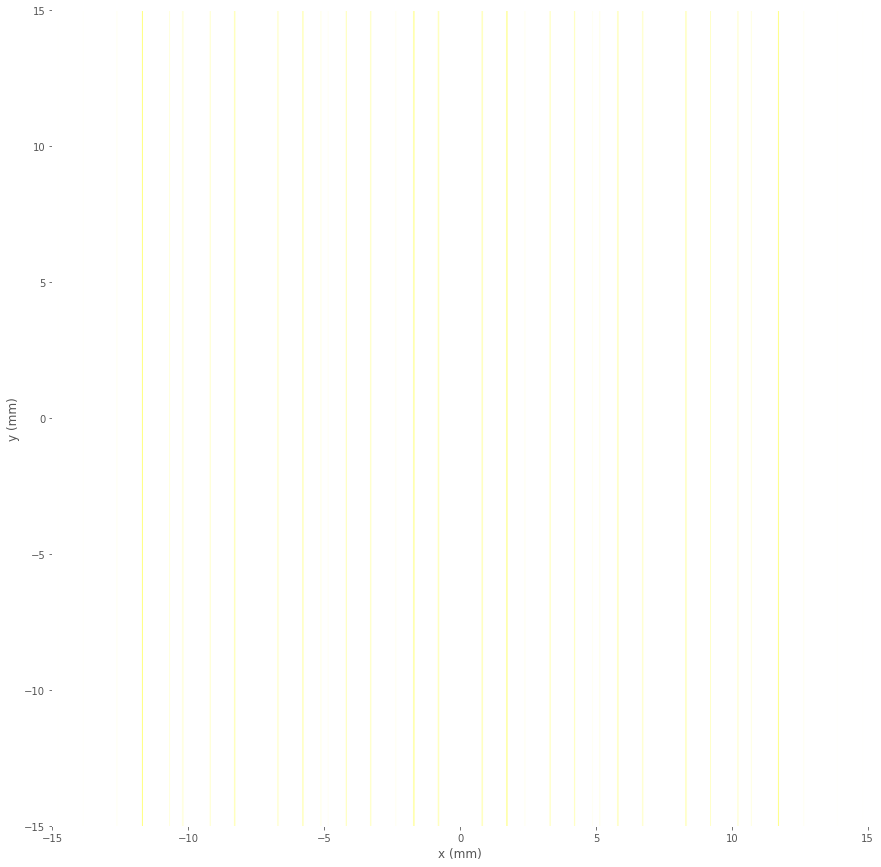

In [0]:
fig, ax = plot(output)
plt.xlabel("x (mm)")
plt.show()
fig.savefig("7.png")